In [3]:
!nvidia-smi
import os
HOME = os.getcwd()

print("HOME:", HOME)



zsh:1: command not found: nvidia-smi
HOME: /Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything


In [55]:
%cd {HOME}

import sys
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights
/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights
mkdir: /Users/mohabenel/.Trash/data: File exists
mkdir: 15.46.39/weights: No such file or directory
[Errno 2] No such file or directory: '/Users/mohabenel/.Trash/data 15.46.39/weights/weights'
/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights
/Users/mohabenel/.Trash/data 15.46.39/weights/weights/sam_vit_h_4b8939.pth ; exist: False


In [53]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data



[Errno 2] No such file or directory: '/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights'
/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights
mkdir: /Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights: No such file or directory
[Errno 2] No such file or directory: '/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights/data'
/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights


In [48]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [50]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/weights/sam_vit_h_4b8939.pth'

In [43]:
mask_generator = SamAutomaticMaskGenerator(sam)
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [44]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

[ WARN:0@3938.712] global loadsave.cpp:244 findDecoder imread_('/Users/mohabenel/Desktop/stage_biopsie/segment-anything-main/segment_anything/data/dog.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [13]:
#full segmentation 

'''mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(2, 2),
    titles=['source image', 'segmented image']
)
'''
'''masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)'''

#partial segmentation 


"mask_annotator = sv.MaskAnnotator()\n\ndetections = sv.Detections.from_sam(sam_result=sam_result)\n\nannotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)\n\nsv.plot_images_grid(\n    images=[image_bgr, annotated_image],\n    grid_size=(2, 2),\n    titles=['source image', 'segmented image']\n)\n"

## Segmentation avec bbox 

In [15]:
mask_predictor = SamPredictor(sam)
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [30]:
import base64

'''def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()
''' 

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget




BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [36]:
coord=widget.bboxes
coord

[{'x': 219, 'y': 210, 'width': 298, 'height': 365, 'label': ''}]

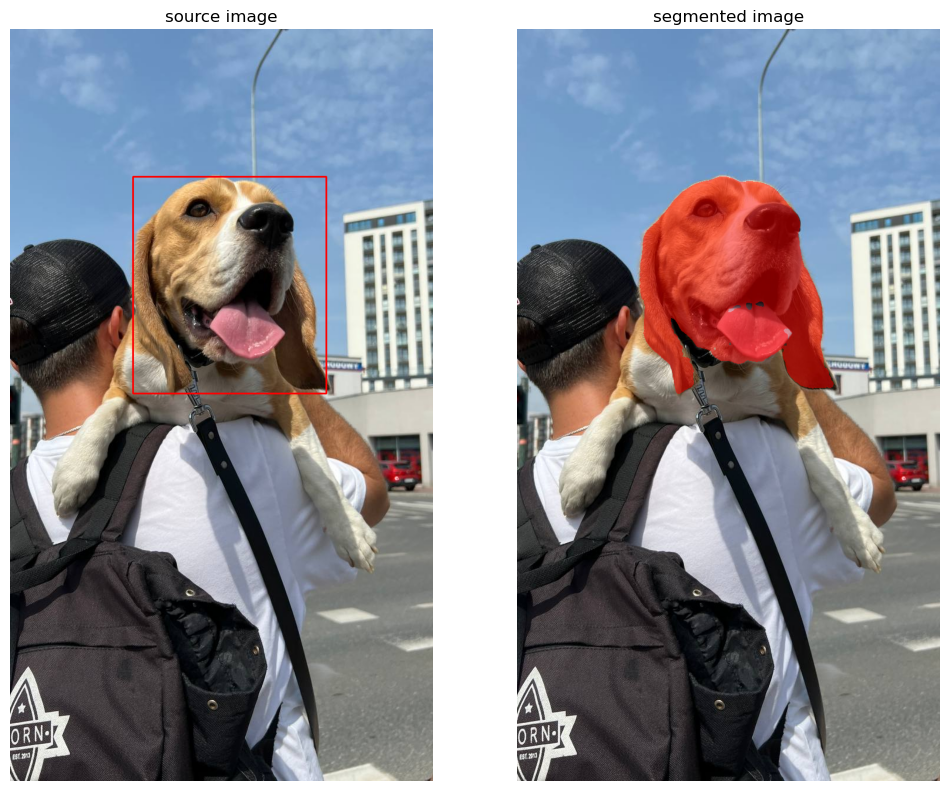

In [40]:
import numpy as np 
bbox=coord

box = widget.bboxes[0] if coord else bbox
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)